In [177]:
# Import libaries
import re
import importlib


In [178]:
# Libary to import self-made libaries
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway\Libaries')

In [179]:
# Importing self-made libaries
import standards as s
import Monte_Carlo as MC
import life_cycle_assessment as lc
import LCA_plots as lp
import box_plot as bp
import LCIA_calculation as calc



In [180]:
# Reload to reset the state of the self-made libaries
def reload_lib(s, MC, lc, lp, bp):
    # https://dev.to/fronkan/importlib-reload-for-resting-modules-between-tests-neh
    importlib.reload(s)
    importlib.reload(MC)
    importlib.reload(lc)
    importlib.reload(lp)
    importlib.reload(bp)

In [181]:
# Path to where the code is stored
path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway'
# Specifying the LCIA method
lcia_method = 'recipe'
reload_lib(s, MC, lc, lp, bp)
flow_legend, database_name, file_name, sheet_name, save_dir, initialization, file_name_unique, db_type = lc.initilization(path, lcia_method)

The chosen project is SU_vs_MU and the chosen database is sterilization
Folder name Results created
Chosen flows:
H200 REC - CONSQ
H200 SU - CONSQ
H400 REC- CONSQ
H400 SU - CONSQ
alubox large + washer - CONSQ
alubox large + wipe - CONSQ
alubox small + washer - CONSQ
alubox small + wipe - CONSQ


In [182]:
df, plot_x_axis_all, impact_categories = lc.quick_LCIA(initialization, file_name, file_name_unique, sheet_name)

Recipe is selected
Initialization is completed
DataFrame with nested lists written to Excel successfully.


In [183]:
df_rearranged = lc.rearrange_dataframe_index(df)

In [184]:
# if calculate_cont == True:
#     sub_proccess, amount = lc.obtaining_sub_process(sub_product_details)
#     FU_sub, FU_sub_process, idx = lc.sub_process_initilization(sub_proccess, FU, database_project, f'df_idx_ofir_{db_type}', lcia_method, db_type)
#     flow_count, flow_sub, functional_unit_sub = lc.FU_contibution_initilization(FU_sub, FU_sub_process)
#     fu_sub_updated = lc.process_update(FU, functional_unit_sub)
    
#     df_cont = lc.LCIA_contribution(impact_category[1], flow_count, FU_sub_process, fu_sub_updated, amount, idx)
#     lc.save_LCA_results(df_cont, file_cont_name, sheet_name, impact_category)
#     df_c = lc.import_LCA_results(file_cont_name, idx, impact_category[1])


In [185]:
if 'recipe' in lcia_method:
    df_res, df_endpoint = lc.recipe_dataframe_split(df_rearranged)
    plot_x_axis_end = plot_x_axis_all[-3:]
    ic_mid = plot_x_axis_all[:-3] 
    plot_x_axis = []
    for ic in ic_mid:
        # print(ic)
        string = re.findall(r'\((.*?)\)', ic)
        if 'ODPinfinite' in  string[0]:
            string[0] = 'ODP'
        elif '1000' in string[0]:
            string[0] = 'GWP'
        plot_x_axis.append(string[0])

else:
    df_res = df_rearranged
    plot_x_axis = plot_x_axis_all

In [186]:
df_tot, df_scaled = lc.dataframe_element_scaling(df_res)
df_col = [df_res.columns[1]]
df_GWP = df_res[df_col]

unique_elements = lc.unique_elements_list(database_name)
colors = s.plot_colors(unique_elements,'turbo')

inputs = [flow_legend, colors, save_dir, db_type, database_name]

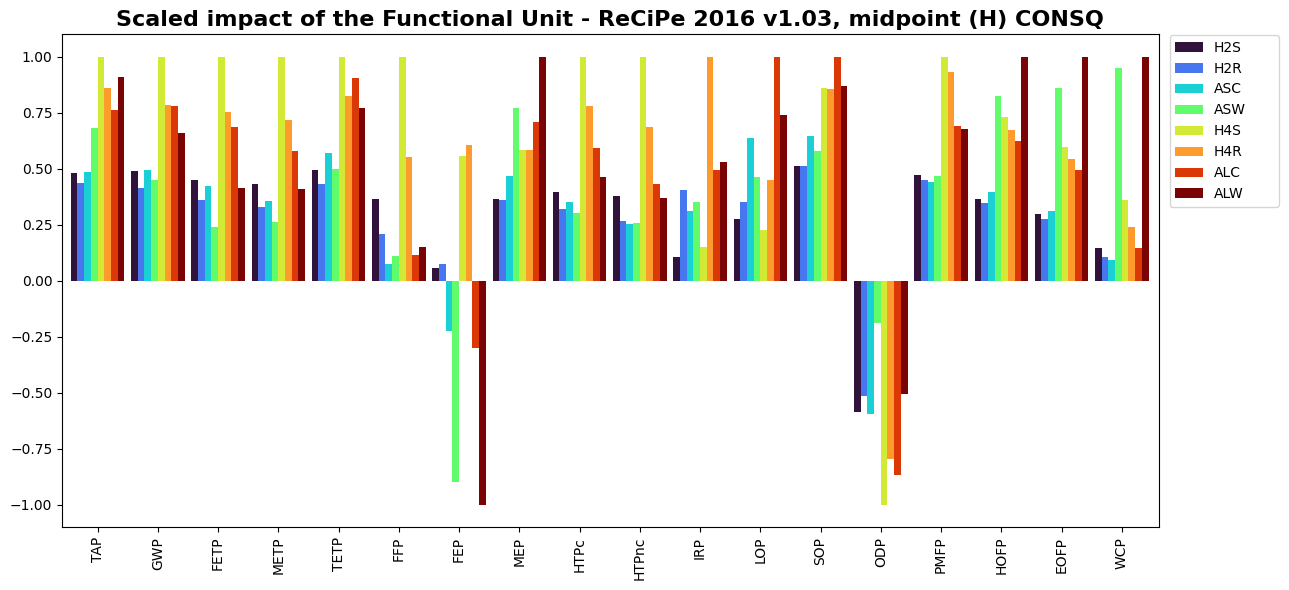

In [187]:
leg_pos_mid = .65

lp.scaled_FU_plot(df_scaled, plot_x_axis, inputs, impact_categories, leg_pos_mid)

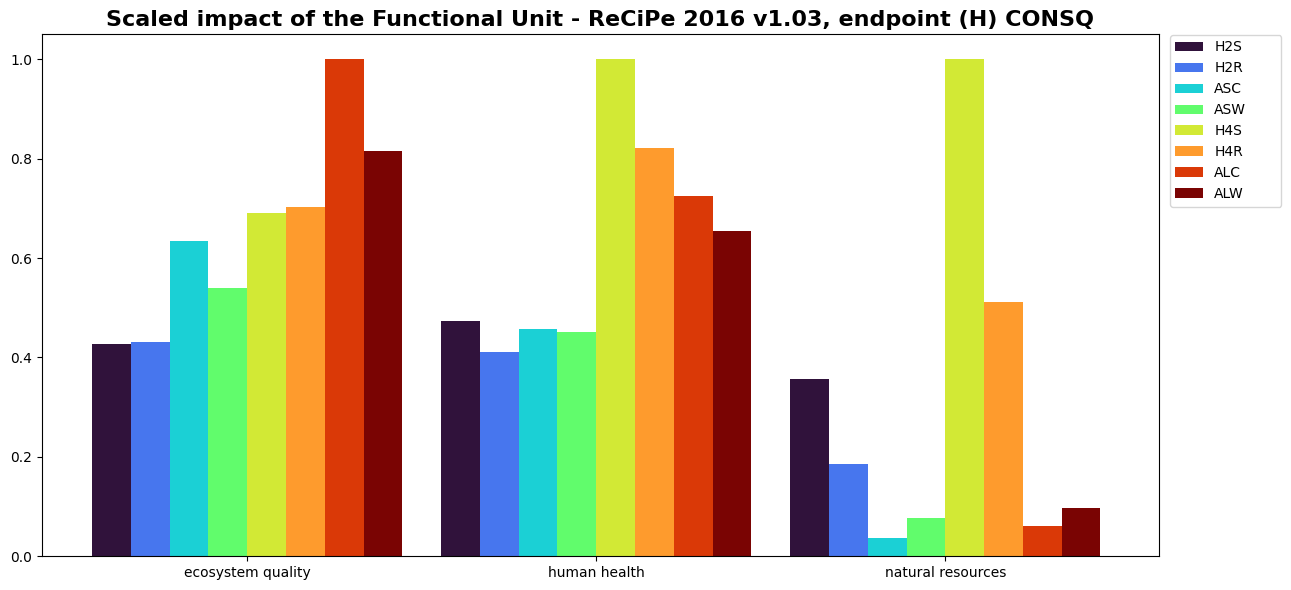

In [188]:
leg_pos_end = 0.67
if 'recipe' in lcia_method.lower():
    df_tot_e, df_scaled_e = lc.dataframe_element_scaling(df_endpoint)
    lp.scaled_FU_plot(df_scaled_e, plot_x_axis_end, inputs, impact_categories[-3:], leg_pos_end)


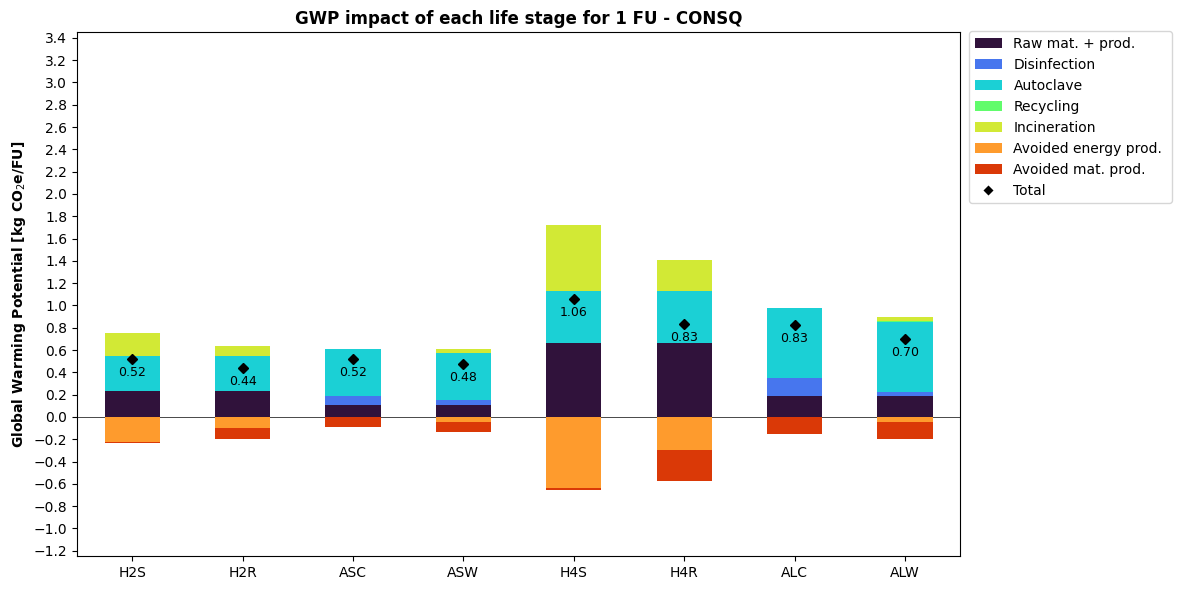

In [189]:
# reload_lib(s, MC, lc, lp, bp)

y_min = -1.2
y_max = 3.4
step = 0.2
leg_pos = 0.674
marker_offset = 0.18
y_axis_values = [y_min, y_max, step, leg_pos, marker_offset]
lp.gwp_scenario_plot(df_GWP, inputs, y_axis_values)


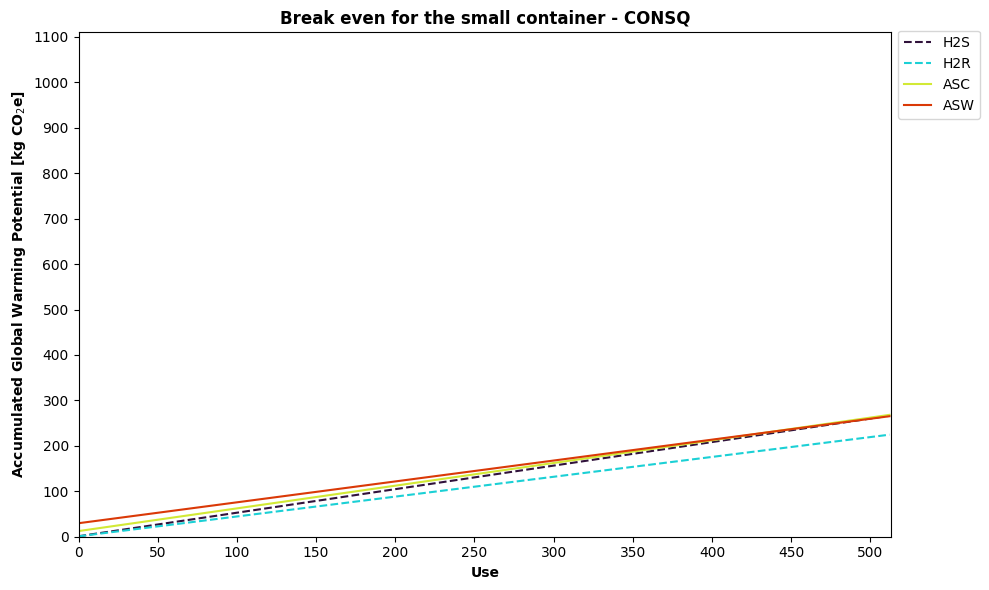

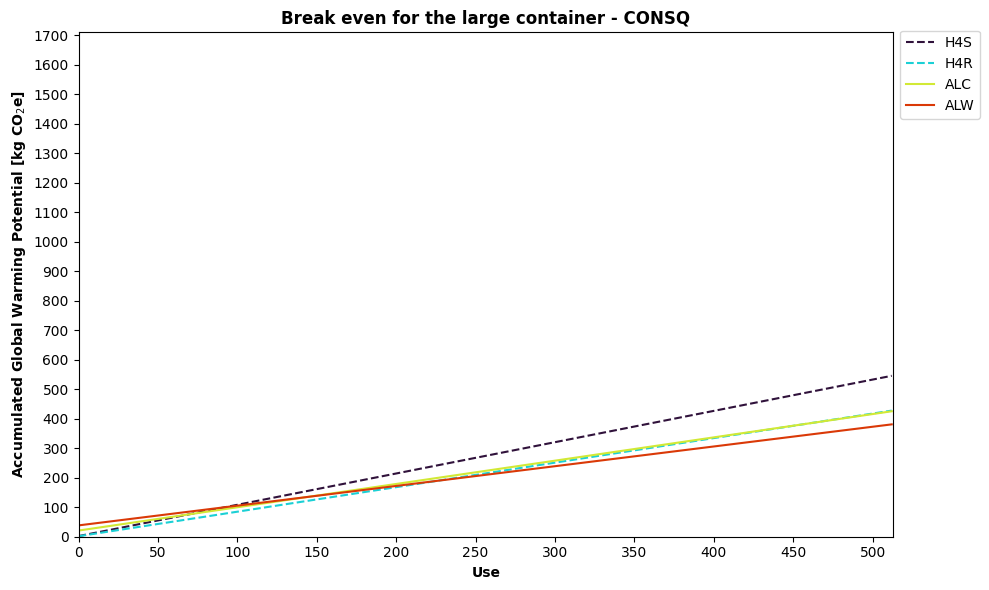

In [190]:
reload_lib(s, MC, lc, lp, bp)

amount_of_uses = 513
y_max = [1100, 1700]
ystep = [100, 100]
xstep = 50
break_even_product = 'container'
color_idx = [0, 2, 4, 6]

plot_controls = [amount_of_uses, y_max, ystep, xstep, break_even_product, color_idx]
lp.break_even_graph(df_GWP, inputs, plot_controls)

In [191]:
import pandas as pd
columns = lc.unique_elements_list(database_name)
case = 'break even'
df_be, ignore = lp.process_categorizing(df_GWP, db_type, database_name, case, flow_legend, columns)


df_be_copy = lp.break_even_orginization(df_be, database_name)


# Split index into small and large based on criteria
small_idx = [idx for idx in df_be_copy.index if '2' in idx or 'AS' in idx]
large_idx = [idx for idx in df_be_copy.index if idx not in small_idx]

# Create empty DataFrames for each scenario
scenarios = {
    'small': pd.DataFrame(0, index=small_idx, columns=df_be_copy.columns, dtype=object),
    'large': pd.DataFrame(0, index=large_idx, columns=df_be_copy.columns, dtype=object)
}



# Fill scenarios with data
for sc_idx, (scenario_name, scenario_df) in enumerate(scenarios.items()):
    scenario_df.update(df_be_copy.loc[scenario_df.index])

    alu_box_use, production = {}, {}

    for idx, row in scenario_df.iterrows(): 
        use, prod = 0, 0
        for col in df_be_copy.columns:
            if ('Autoclave' in col or 'Disinfection' in col) and 'H' not in idx:
                alu_box_use[idx] = row[col] + use
                use += row[col]
            elif 'A' in idx:
                production[idx] = (row[col] + prod) * amount_of_uses
                prod += row[col]
                
            else:
                production[idx] = row[col] + prod
                prod += row[col]


In [192]:
production

{'H4S': 1.0613450284246062,
 'H4R': 0.8318410602669646,
 'ALC': 20.0723315614131,
 'ALW': 37.7393781966193}

In [193]:
alu_box_use

{'ALC': 0.7900058652549531, 'ALW': 0.6689168318811942}

In [194]:
proc_keys = [key for key in production.keys()]
proc_keys

['H4S', 'H4R', 'ALC', 'ALW']

In [195]:

ALC_be_R = 0
ALC_be_S = 0
ALW_be_R = 0
ALW_be_S = 0

ALC_be = {}
ALW_be = {}

h4r_old = 0
h4s_old = 0

a, b, c, d  = 0, 0, 0, 0

variable_use = range(1,10000,1)
for use in variable_use:
    h4r = production[proc_keys[0]] * use 
    h4s = production[proc_keys[1]] * use
    alc = (production[proc_keys[2]] * amount_of_uses/use + alu_box_use[proc_keys[2]]*use)
    alw = (production[proc_keys[3]] * amount_of_uses/use + alu_box_use[proc_keys[3]]*use)
    # print(h4r, h4s, alc, alw)
    if alc < h4r:
        if alc > h4r_old and a == 0:
            ALC_be[proc_keys[0]] = use
            a = 1
            print(f'Alu + cabinet break even after {use} uses compared to recycled H400')
    if alc < h4s:
        if alc > h4s_old and b == 0:
            ALC_be[proc_keys[1]] = use
            print(f'Alu + cabinet break even after {use} uses compared to SU H400')
            b = 1
    if alw < h4r and c == 0:
        if alw > h4r_old:
            ALC_be[proc_keys[0]] = use
            print(f'Alu + wipe break even after {use} uses compared to recycled H400')
            c = 1
    if alw < h4s:
        if alw > h4s_old and d == 0:
            ALC_be[proc_keys[1]] = use
            print(f'Alu + wipe break even after {use} uses compared to SU H400')
            d = 1

    h4r_old = h4r
    h4s_old = h4s
            
                      

Alu + cabinet break even after 195 uses compared to recycled H400
Alu + wipe break even after 223 uses compared to recycled H400
Alu + wipe break even after 345 uses compared to SU H400
Alu + cabinet break even after 497 uses compared to SU H400


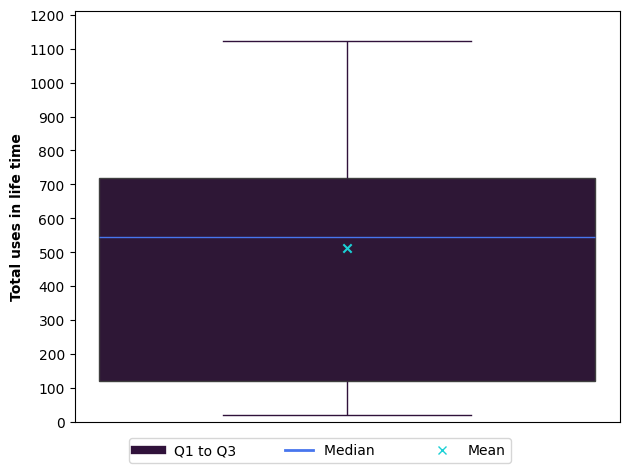

In [124]:
reload_lib(s, MC, lc, lp, bp)
color_Q1_Q3 = 0
color_median = 1
color_mean = 2
y_label = 'Total uses in life time'
save_name = 'alu_container'
leg_size = 0.7
y_min = 0
y_max = 1210
ystep = 100
life_time = 10

path_box_plot = r"C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Single-use-vs-multi-use-in-health-care\Data\container.xlsx"

plot_structure = [color_Q1_Q3, color_median, color_mean, y_label, save_name, leg_size, y_min, y_max, ystep, life_time]

bp.box_plot(path_box_plot, inputs, plot_structure)